# Modelos de Scoring para Riesgo de Crédito (Personas Naturales)


Esta aplicación incorpora el proceso de scoring de crédito incluyendo:

* un análisis exploratorio de datos (EDA)  
* analisis de las caracteristicas de los clientes o sujetos de crédito (variables claves)
* estimación de la Probabilidad de Incumplimiento (PD) y segmentación de los clientes (buenos y malos) - generación del Score. Está segmentación permite clasificar clientes en categorías de riesgo basadas en su score, lo que permite tomar decisiones estandarizadas (ej. aprobar, rechazar o revisar manualmente).
* pronostico de nuevos clientes y creditos

En esta aplicación usaremos una muestra pequeña de datos extraida de un gran dataset con información disponible de créditos.

**Conceptos clave**:

* Análisis exploratorio de datos (EDA): es la fase inicial de investigación del proceso de análisis de datos en la que se examinan los datos mediante métodos estadísticos y visualizaciones para comprender sus principales características, descubrir patrones y relaciones, e identificar anomalías o problemas de calidad de los datos. El EDA ayuda a orientar la selección de modelos estadísticos adecuados y garantizar que los datos sean lo suficientemente sólidos como para su posterior análisis o aprendizaje automático.
* Probabilidad de incumplimiento (PD): probabilidad de que un prestatario no pague un préstamo.
* scoring crediticio (scoring): número o puntuación que refleja tu historial y comportamiento financiero, indicando a los prestamistas la probabilidad de que pagues tus deudas.
* Modelo logit (o regresión logística): modelo estadístico que estima la probabilidad de un evento binario (con solo dos resultados posibles) usando una función logística para que la probabilidad esté acotada entre 0 y 1.

1. Configuración del Entorno e Importación de Librerías
---

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
files.upload()                 # Buscar y cargar de la carpeta donde estan los archivos

Cargamos el conjunto de datos `credit_risk.xlsx` y realizamos un análisis inicial para entender su estructura, identificar valores nulos y comprender la distribución de las variables.

In [ ]:
datos = pd.read_excel('credit_risk.xlsx')
datos.head(3)

,Unnamed: 0,id,loan_amnt,int_rate,grade,emp_title,emp_length,home_ownership,annual_inc,loan_status
0,0,68407277,3600,13.99,C,leadman,10.0,MORTGAGE,55000.0,Fully Paid
1,1,68355089,24700,11.99,C,Engineer,10.0,MORTGAGE,65000.0,Fully Paid
2,2,68341763,20000,10.78,B,truck driver,10.0,MORTGAGE,63000.0,Fully Paid


## Análisis exploratorio de datos (EDA)

In [ ]:
# Información general del DataFrame
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      10000 non-null  int64  
 1   id              10000 non-null  int64  
 2   loan_amnt       10000 non-null  int64  
 3   int_rate        10000 non-null  float64
 4   grade           10000 non-null  object 
 5   emp_title       9443 non-null   object 
 6   emp_length      9451 non-null   float64
 7   home_ownership  10000 non-null  object 
 8   annual_inc      10000 non-null  float64
 9   loan_status     10000 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 781.4+ KB


**Descripcion de las variables númericas**

In [ ]:
# Resumen estadístico de las variables numéricas
datos.describe()

,Unnamed: 0,id,loan_amnt,int_rate,emp_length,annual_inc
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9451.000000,1.000000e+04
mean,4999.50000,6.804055e+07,15104.437500,12.295983,5.901704,7.888008e+04
std,2886.89568,1.974650e+06,8717.527683,4.304762,3.756612,6.440111e+04
min,0.00000,3.617740e+05,1000.000000,5.320000,0.000000,1.770000e+03
25%,2499.75000,6.788920e+07,8000.000000,9.170000,2.000000,4.900000e+04
50%,4999.50000,6.824256e+07,14000.000000,11.990000,6.000000,6.800000e+04
75%,7499.25000,6.847419e+07,20000.000000,14.850000,10.000000,9.500000e+04
max,9999.00000,6.861706e+07,35000.000000,28.990000,10.000000,3.964280e+06


Además, se pueden construir histogramas u otros gráficos para identificar patrones o características particulares de cada variable.

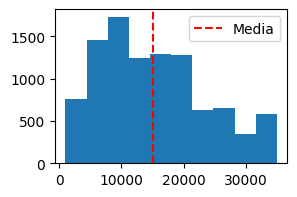

In [ ]:
plt.figure(figsize=(3,2))
plt.hist(datos['loan_amnt'])
plt.axvline(datos['loan_amnt'].mean(), color='red', linestyle='--', label='Media')
plt.legend();

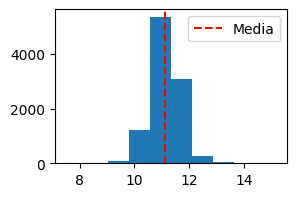

In [ ]:
plt.figure(figsize=(3,2))
plt.hist(np.log(datos['annual_inc']))
plt.axvline(np.log(datos['annual_inc']).mean(), color='red', linestyle='--', label='Media')
plt.legend();

Identificación de categorías o datos relevantes en las variables de interés:


In [ ]:
datos['home_ownership'].value_counts()

,count
home_ownership,
MORTGAGE,4925
RENT,3934
OWN,1141


In [ ]:
datos['loan_status'].value_counts()

,count
loan_status,
Fully Paid,7189
Charged Off,1713
Current,1024
Late (31-120 days),58
In Grace Period,12
Late (16-30 days),4


In [ ]:
datos['grade'].value_counts()

,count
grade,
B,3000
C,2873
A,1824
D,1371
E,683
F,210
G,39


## Limpieza y Preprocesamiento de Datos

**Definición de la Variable Objetivo (Default)**

El riesgo de crédito se centra en predecir el incumplimiento. Crearemos una variable binaria (0 = No Incumplimiento, 1 = Incumplimiento) a partir de la columna loan_status. Aquí, definimos la variable objetivo `default` y procesamos las características para que sean adecuadas para el modelo.

In [ ]:
datos['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)'], dtype=object)

default
0    0.8229
1    0.1771
Name: proportion, dtype: float64


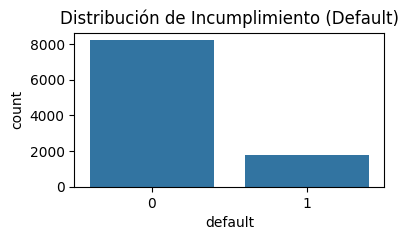

In [ ]:
# Estados que consideramos como 'Incumplimiento' (Default)
default_status = [
    'Charged Off',     # Cartera vencida o castigada
    'Default',         # Cesación de pagos
    'Does not meet the credit policy. Status:Charged Off',
    'Late (31-120 days)'  # Mora
]

#3 Esto significa que los creditos que no entraron en default son:
##non-default = ['Fully Paid', 'Current', 'In Grace Period','Late (16-30 days)']

# Creamos la variable objetivo 'default'
datos['default'] = np.where(datos['loan_status'].isin(default_status), 1, 0)

# Visualizamos la distribución
print(datos['default'].value_counts(normalize=True))
plt.figure(figsize=(4,2))
sns.countplot(x='default', data=datos)
plt.title('Distribución de Incumplimiento (Default)')
plt.show()

Limpiamos la variable 'emp_length' (antigüedad laboral)

In [ ]:
# Rellenamos nulos con 0 y extraemos solo los números
datos['emp_length'] = datos['emp_length'].fillna('0')
#datos.info()

Ajustamos las variables que requieran ajustes

In [ ]:
# Rellenamos nulos con 0 y extraemos solo los números
datos['emp_length'] = datos['emp_length'].fillna('0')
#datos.info()

**Seleccionamos un subconjunto de variables relevantes para el modelo**

In [ ]:
features = ['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'default']
datos_model = datos[features].copy()
datos_model.head(3)

,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,default
0,3600,13.99,C,10.0,MORTGAGE,55000.0,0
1,24700,11.99,C,10.0,MORTGAGE,65000.0,0
2,20000,10.78,B,10.0,MORTGAGE,63000.0,0


Eliminamos filas con valores nulos en las variables seleccionadas (si las hay)

In [ ]:
datos_model.dropna(inplace=True)
#datos_model

Análisis de Características Clave
---

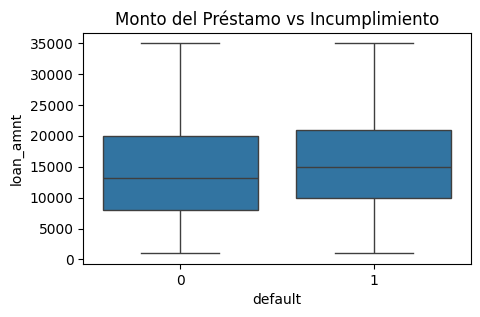

In [ ]:
# Monto del Préstamo
plt.figure(figsize=(5, 3))
plt.title('Monto del Préstamo vs Incumplimiento')
sns.boxplot(x='default', y='loan_amnt', data=datos_model);

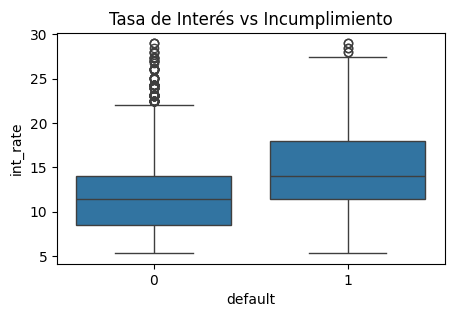

In [ ]:
# Tasa de interés
plt.figure(figsize=(5, 3))
plt.title('Tasa de Interés vs Incumplimiento')
sns.boxplot(x='default', y='int_rate', data=datos_model);

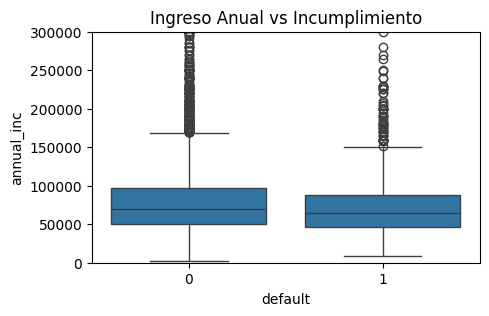

In [ ]:
# Ingreso Anual
plt.figure(figsize=(5, 3))
plt.title('Ingreso Anual vs Incumplimiento')
sns.boxplot(x='default', y='annual_inc', data=datos_model)
plt.ylim(0, 300000); # Limitar para mejor visualización

## Preparación de Datos para el Modelo

Convertimos las variables categóricas en variables dummy para que puedan ser utilizadas por el modelo de regresión logística.

In [ ]:
# Convertir variables categóricas a dummies\n",
df_dummies = pd.get_dummies(datos_model, columns=['grade', 'home_ownership'], drop_first=True)
print("Columnas después de la codificación one-hot:")
print(df_dummies.columns)
df_dummies.head(3)

Columnas después de la codificación one-hot:
Index(['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'default',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='object')


,loan_amnt,int_rate,emp_length,annual_inc,default,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OWN,home_ownership_RENT
0,3600,13.99,10.0,55000.0,0,False,True,False,False,False,False,False,False
1,24700,11.99,10.0,65000.0,0,False,True,False,False,False,False,False,False
2,20000,10.78,10.0,63000.0,0,True,False,False,False,False,False,False,False


## Estimación del Modelo de Probabilidad de Incumplimiento (PD)
Dividimos los datos en conjuntos de entrenamiento y prueba, y entrenamos un modelo de regresión logística.

In [ ]:
# Definir variables independientes (X) y dependiente (y)
X = df_dummies.drop('default', axis=1)
y = df_dummies['default']

# Dividir los datos en entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar el modelo de Regresión Logística
# Usamos class_weight='balanced' para manejar el desbalance en la variable objetivo
log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_model.fit(X_train, y_train)
print("Modelo de Regresión Logística entrenado exitosamente")

Modelo de Regresión Logística entrenado exitosamente


## Evaluación del Modelo

Accuracy Score:  0.6385
Matriz de Confusión:


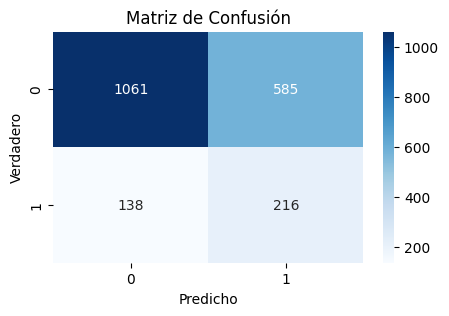

In [ ]:
# Realizar predicciones en el conjunto de prueba\n",
y_pred = log_model.predict(X_test)
y_pred_proba = log_model.predict_proba(X_test)[:, 1]

# Métricas de evaluación
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Matriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
print("Reporte de Clasificación: ")
print(classification_report(y_test, y_pred))
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

Reporte de Clasificación: 
              precision    recall  f1-score   support

           0       0.88      0.64      0.75      1646
           1       0.27      0.61      0.37       354

    accuracy                           0.64      2000
   macro avg       0.58      0.63      0.56      2000
weighted avg       0.78      0.64      0.68      2000



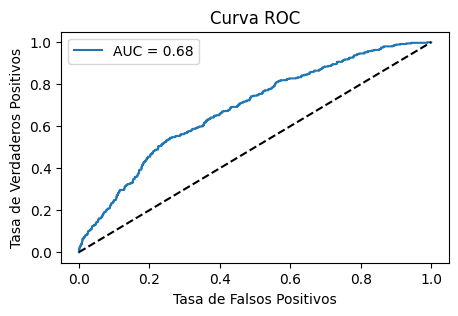

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show();

## Generación del Scorecard y Segmentación

Un scorecard de crédito traduce la probabilidad de incumplimiento (PD) en un puntaje numérico fácil de interpretar. Un puntaje más alto generalmente indica un menor riesgo.

Usaremos una transformación lineal simple de la razón de momios (log-odds) para crear el score. La fórmula es:

$$ \text{Score} = \text{Offset} - \text{Factor} \times \log(\text{odds}) $$

Donde:
* `Offset` y `Factor` son constantes que escalan el puntaje a un rango deseado (e.g., 300-850).
* `odds = p / (1 - p)`, con `p` siendo la PD estimada.

Parámetros para la transformación del score:

Queremos que un score de 600 corresponda a una PD de 5% (odds de 1/19); y que un aumento de 20 puntos en el score duplique los odds (PDO = 20).


In [ ]:
factor = 20 / np.log(2)
offset = 600 - factor * np.log(1/19)

In [ ]:
def calculate_score(pd, offset, factor):
  # Evitar división por cero o log(0)
  pd = np.clip(pd, 0.0001, 0.9999)
  odds = pd / (1 - pd)
  score = offset - factor * np.log(odds)
  return score.astype(int)

In [ ]:
# Calcular PD y Score para todo el dataset
df_dummies['pd'] = log_model.predict_proba(X)[:, 1]
df_dummies['score'] = calculate_score(df_dummies['pd'], offset, factor)

print("Ejemplo de clientes con su PD y Score calculado: ")
display(df_dummies[['default', 'pd', 'score']].head(10))

Ejemplo de clientes con su PD y Score calculado: 


,default,pd,score
0,0,0.483670,686
1,0,0.451535,690
2,0,0.393655,697
3,0,0.570353,676
4,0,0.695060,661
5,0,0.567164,677
6,0,0.299625,709
7,0,0.305748,708
8,0,0.201941,724
9,0,0.400125,696


## Análisis de la Distribución del Score

Visualizamos cómo se distribuye el score para los clientes buenos (sin incumplimiento) y malos (con incumplimiento). Idealmente, deberíamos ver una separación clara, con los clientes malos concentrados en los puntajes más bajos.

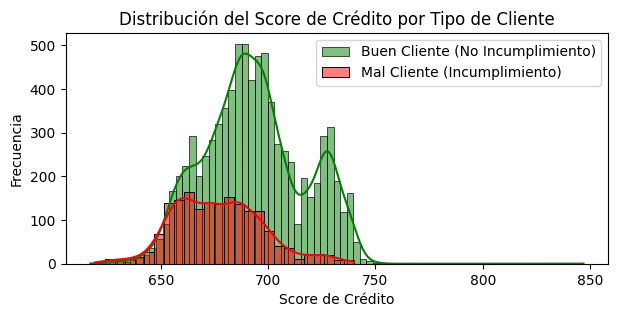

In [ ]:
plt.figure(figsize=(7, 3))
sns.histplot(df_dummies[df_dummies['default'] == 0]['score'], color='g', label='Buen Cliente (No Incumplimiento)', kde=True)
sns.histplot(df_dummies[df_dummies['default'] == 1]['score'], color='r', label='Mal Cliente (Incumplimiento)', kde=True)
plt.title('Distribución del Score de Crédito por Tipo de Cliente')
plt.xlabel('Score de Crédito')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

## Segmentación de Clientes

Definimos puntos de corte para segmentar a los clientes según su score

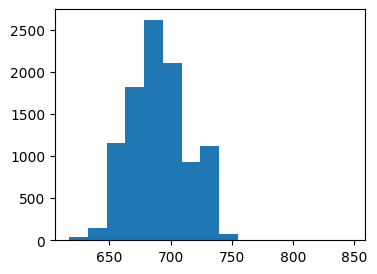

In [ ]:
# Ditribución de los scores
plt.figure(figsize=(4, 3))
plt.hist(df_dummies['score'],bins=15);

In [ ]:
def segment_customer(score):
  if score >= 670:
    return '1. Riesgo Bajo'
  elif score >= 600:
    return '2. Riesgo Moderado'
  elif score >= 550:
    return '3. Riesgo Alto'
  else:
    return '4. Riesgo Muy Alto'

In [ ]:
df_dummies['segmento_riesgo'] = df_dummies['score'].apply(segment_customer)
print("Distribución de clientes por segmento de riesgo: ")
segment_distribution = df_dummies['segmento_riesgo'].value_counts().sort_index()
print(segment_distribution)

Distribución de clientes por segmento de riesgo: 
segmento_riesgo
1. Riesgo Bajo        7978
2. Riesgo Moderado    2022
Name: count, dtype: int64


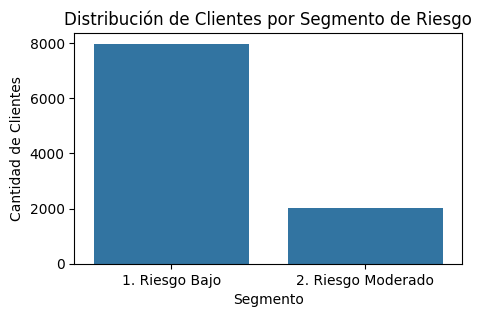

In [ ]:
plt.figure(figsize=(5,3))
sns.barplot(x=segment_distribution.index, y=segment_distribution.values)
plt.title('Distribución de Clientes por Segmento de Riesgo')
plt.xlabel('Segmento')
plt.ylabel('Cantidad de Clientes')
plt.show();

## Pronóstico para Nuevos Clientes

Finalmente, utilizamos el modelo y el scorecard para evaluar a nuevos solicitantes de crédito

In [ ]:
# Crear un DataFrame con datos de nuevos clientes
nuevos_clientes = pd.DataFrame({'loan_amnt': [15000, 25000, 5000],
                                'int_rate': [12.5, 18.2, 8.9],
                                'grade': ['C', 'E', 'A'],
                                'emp_length': [5, 2, 10],
                                'home_ownership': ['RENT', 'MORTGAGE', 'OWN'],
                                'annual_inc': [50000, 75000, 90000]})

print("Datos de nuevos clientes: ")
display(nuevos_clientes)

Datos de nuevos clientes: 


,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc
0,15000,12.5,C,5,RENT,50000
1,25000,18.2,E,2,MORTGAGE,75000
2,5000,8.9,A,10,OWN,90000


In [ ]:
# Preprocesar los datos de los nuevos clientes (aplicar one-hot encoding)
# Es crucial usar las mismas columnas que en el set de entrenamiento
nuevos_clientes_dummies = pd.get_dummies(nuevos_clientes, columns=['grade', 'home_ownership'], drop_first=True)
nuevos_clientes_aligned = nuevos_clientes_dummies.reindex(columns=X_train.columns, fill_value=0)
print("Datos de nuevos clientes preprocesados: ")
display(nuevos_clientes_aligned)

Datos de nuevos clientes preprocesados: 


,loan_amnt,int_rate,emp_length,annual_inc,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OWN,home_ownership_RENT
0,15000,12.5,5,50000,0,True,0,False,0,0,False,True
1,25000,18.2,2,75000,0,False,0,True,0,0,False,False
2,5000,8.9,10,90000,0,False,0,False,0,0,True,False


In [ ]:
# Estimar la PD, calcular el score y asignar segmento
pd_nuevos = log_model.predict_proba(nuevos_clientes_aligned)[:, 1]
score_nuevos = calculate_score(pd_nuevos, offset, factor)
nuevos_clientes['pd_estimada'] = pd_nuevos
nuevos_clientes['score'] = score_nuevos
nuevos_clientes['segmento_riesgo'] = nuevos_clientes['score'].apply(segment_customer)
print(" Resultados del Scoring para Nuevos Clientes: ")
display(nuevos_clientes)

 Resultados del Scoring para Nuevos Clientes: 


,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,pd_estimada,score,segmento_riesgo
0,15000,12.5,C,5,RENT,50000,0.532853,681,1. Riesgo Bajo
1,25000,18.2,E,2,MORTGAGE,75000,0.624310,670,1. Riesgo Bajo
2,5000,8.9,A,10,OWN,90000,0.264019,714,1. Riesgo Bajo


# Cómo podemos mejorar el desempeño del modelo

**1. Datos Desbalanceados**: los datos disponibles suelen tener muchos más clientes que pagaron sus préstamos ("buenos clientes", clase 0) que aquellos que incumplieron ("malos clientes", clase 1).

Esto genera un impacto negativo en su desempeño: un modelo entrenado con datos desbalanceados tiende a volverse "perezoso". Aprende a predecir mayoritariamente la clase dominante (clase 0) porque así obtiene una alta precisión (accuracy) general. Sin embargo, falla en su tarea más importante: identificar a los clientes riesgosos (clase 1). Esto se reflejaba en un bajo indicador de recall para la clase 1.

**¿Qué podemos hacer para corregir el problema?**

**Propuesta 1: Balanceo de Datos con SMOTE**
Se puede usa la técnica de sobremuestreo llamada SMOTE (Synthetic Minority Over-sampling Technique). ¿Qué es SMOTE? En lugar de simplemente duplicar los ejemplos de la clase minoritaria (los "malos clientes"), SMOTE crea nuevos datos sintéticos que son similares a los casos de incumplimiento existentes. Esto expone al modelo a una variedad mayor y más rica de ejemplos de riesgo, permitiéndole aprender patrones más robustos.

**Recomendaciones para su implementación adecuada:**

* Aplicar SMOTE únicamente al conjunto de entrenamiento.

* El conjunto de prueba se mantiene en su estado original y desbalanceado para simular un escenario real y evaluar el rendimiento del modelo de manera honesta.

**Resultados epserados**

* El entrenamiento del modelo de Regresión Logística con los datos balanceados por SMOTE peude generar una mejora significativa en las métricas de desempeño clave como *aumento Recall* (Sensibilidad). El nuevo modelo es mucho más efectivo para detectar a los clientes que realmente van a incumplir.

* Trade-off de Precisión (Precision). Es común que al mejorar el recall la precision disminuya ligeramente. Esto significa que el modelo podría clasificar incorrectamente a unos pocos clientes buenos como riesgosos (falsos positivos). Sin embargo, en el contexto de riesgo de crédito, este es un "costo" aceptable, ya que es preferible revisar a un cliente bueno adicional que dejar pasar a un cliente que va a generar una pérdida (falso negativo).

* Precisión General (Accuracy). EL accuracy puedo disminuir un poco, lo cual es normal. Esta métrica puede ser engañosa en datos desbalanceados, y el recall para la clase de interés (incumplimiento) es un indicador mucho más relevante para este problema de negocio.

In [ ]:
from imblearn.over_sampling import SMOTE # Nueva libreria

1. División de Datos y Balanceo con SMOTE. Dividimos los datos en entrenamiento y prueba. **Es crucial aplicar SMOTE únicamente al conjunto de entrenamiento** para evitar filtrar información al conjunto de prueba y obtener una evaluación realista del modelo.

In [ ]:
#Convertir variables categóricas a dummies (One-Hot Encoding)
df_dummies = pd.get_dummies(datos_model, columns=['grade', 'home_ownership'], drop_first=True)

# X contiene solo las variables predictoras numéricas
# Definir variables independientes (X) y dependiente (y)
X = df_dummies.drop('default', axis=1)
y = df_dummies['default']

In [ ]:
# Dividir los datos en entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#print("Distribución de clases antes de SMOTE:")

In [ ]:
# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Distribución de clases después de SMOTE: ")
print(y_train_smote.value_counts())
print("El balanceo se completó exitosamente")

Distribución de clases después de SMOTE: 
default
0    6583
1    6583
Name: count, dtype: int64
El balanceo se completó exitosamente


**Entrenamiento y Evaluación del Modelo con SMOTE**

In [ ]:
# Entrenar el modelo con los datos balanceados
log_model_balanced = LogisticRegression(max_iter=1000, random_state=42)
log_model_balanced.fit(X_train_smote, y_train_smote)
print("Modelo entrenado. ")

# Evaluar el modelo en el conjunto de prueba (que no fue balanceado)
y_pred_balanced = log_model_balanced.predict(X_test)
print("Evaluación del Modelo Mejorado (con SMOTE)")
print("Accuracy Score: ", accuracy_score(y_test, y_pred_balanced))
print("Reporte de Clasificación: ")
print(classification_report(y_test, y_pred_balanced))

Modelo entrenado. 
Evaluación del Modelo Mejorado (con SMOTE)
Accuracy Score:  0.756
Reporte de Clasificación: 
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1646
           1       0.26      0.21      0.24       354

    accuracy                           0.76      2000
   macro avg       0.55      0.54      0.54      2000
weighted avg       0.74      0.76      0.75      2000



Matriz de Confusión: 


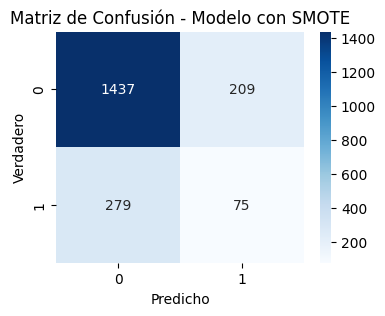

In [ ]:
print("Matriz de Confusión: ")
cm = confusion_matrix(y_test, y_pred_balanced)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - Modelo con SMOTE')
plt.show();

In [ ]:
# Calcular PD y Score para todo el dataset original (df_dummies)
df_dummies['pd'] = log_model_balanced.predict_proba(X)[:, 1]
df_dummies['score'] = calculate_score(df_dummies['pd'], offset, factor)

In [ ]:
# Aplicar la segmentación
df_dummies['segmento_riesgo'] = df_dummies['score'].apply(segment_customer)
print("DataFrame con PD, Score y Segmento calculados: ")
display(df_dummies[['default', 'pd', 'score', 'segmento_riesgo']].head())

DataFrame con PD, Score y Segmento calculados: 


,default,pd,score,segmento_riesgo
0,0,0.236052,718,1. Riesgo Bajo
1,0,0.285973,711,1. Riesgo Bajo
2,0,0.164004,731,1. Riesgo Bajo
3,0,0.331161,705,1. Riesgo Bajo
4,0,0.191667,726,1. Riesgo Bajo


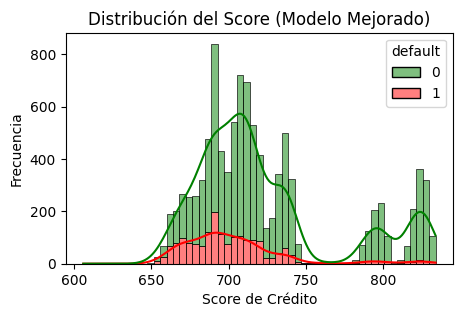

In [ ]:
plt.figure(figsize=(5, 3))
sns.histplot(data=df_dummies, x='score', hue='default', multiple='stack', palette=['g', 'r'], kde=True)
plt.title('Distribución del Score (Modelo Mejorado)')
plt.xlabel('Score de Crédito')
plt.ylabel('Frecuencia')
plt.show();

In [ ]:
print("\nAnálisis de la Tasa de Incumplimiento por Segmento: ")
segment_analysis = df_dummies.groupby('segmento_riesgo')['default'].agg(['count', 'mean']).rename(columns={'count': 'Num_Clientes', 'mean': 'Tasa_Default'})
segment_analysis['Tasa_Default'] = (segment_analysis['Tasa_Default'] * 100).round(2)
display(segment_analysis)


Análisis de la Tasa de Incumplimiento por Segmento: 


,Num_Clientes,Tasa_Default
segmento_riesgo,,
1. Riesgo Bajo,9442,16.60
2. Riesgo Moderado,558,36.56


## Selección de Variables para el Modelo

### Valor de la Información (IV) y Peso de la Evidencia (WoE)

Valor de la Información (IV) y Peso de la Evidencia (WoE), son las mejores prácticas de la industria para la selección de variables en el modelado de riesgo crediticio.

* Peso de la Evidencia (WoE): Esta técnica mide el poder predictivo de un solo atributo en relación con el resultado. Consiste en agrupar una variable en categorías y calcular el logaritmo de la proporción de clientes "buenos" y "malos" en cada categoría. El WoE ayuda a crear una relación lineal entre las variables y el logaritmo de las probabilidades de incumplimiento, lo cual es ideal para un modelo de regresión logística.

* Valor de Información (IV): El IV mide el poder predictivo general de una variable en todos sus intervalos. Se calcula a partir de los valores de WoE de todos sus grupos o categorías. Nos dice qué tan bien una variable, en su conjunto, puede separar a los clientes buenos de los malos. Utilizar el IV para realizar una preselección de variables es una técnica clásica y muy potente en la construcción de modelos de scoring. Este método nos permitirá:

* Reducir el Ruido: Descartar variables que no tienen poder predictivo.
* Mejorar la Robustez: Seleccionar variables con una relación estadística sólida y comprensible con el riesgo de quiebra.
* Incorporar Criterios de Negocio: Analizar el Weight of Evidence (WoE) de cada variable para asegurar que su comportamiento tenga sentido desde una perspectiva financiera.

Para interpretar el IV, se suele usar la siguiente regla general:

* **< 0.1**: Poder predictivo débil.
* **0.1 - 0.3**: Poder predictivo medio.
* **0.3 - 0.5**: Poder predictivo fuerte.
* **> 0.5**: Sospechoso, probablemente sobreajustado.

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [ ]:
iv, woe = iv_woe(data = datos_model, target = 'default', bins=10, show_woe = True)

In [ ]:
iv.index = iv['Variable']
iv = iv['IV']
iv

,IV
Variable,
loan_amnt,0.031991
int_rate,0.514297
grade,0.493654
emp_length,0.012343
home_ownership,0.045986
annual_inc,0.027692


# Extensiones

1. Incluir más varables explicativas
2. Modelos de estimación logística más "robustos":

* Modelo con penalización L2 (ridge)
* Modelo con penalización L1 (LASSO)